# NEST Benchmarks

We have run the following benchmarks:
- Synthetic benchmarks
  - HPC bencmark.
  - HPC bencmark split into many `Connect` calls.
    - One where we time each connection 'bulk' to get connections/second
    - One where we time all connections together, like in the normal HPC benchmark.
  - HPC benchmark where we use the same connection rule for all `Connect` calls (`one_to_one`, `all_to_all`, `fixed_indegree`, `fixed_outdegree`, `fixed_total_number`, `pairwise_bernoulli` and `symmetric_pairwise_bernoulli`) and compute connections/second.
- Realistic benchmarks
  - Multi-area-model
    - See https://github.com/INM-6/multi-area-model
  - 4x4 Mesocircuit model
    - See https://github.com/INM-6/4x4mm2LFP/tree/master


### Specifications

All of the benchmarks were run with the following number of nodes, VPs, scales, threads:

| Nodes | VPs | Scale - hpc | Scale - MAM | Scale - 4x4 | Threads |
|:-----:|:---:|:-----------:|:-----------:|:-----------:|:-------:|
|   1   |  24 |      20     |    0.0625   |    0.0625   |1,4,8,12 |
|   2   |  48 |      40     |    0.125    |    0.125    |1,4,8,12 |
|   4   |  96 |      80     |    0.25     |    0.25     |1,4,8,12 |
|   8   | 192 |     160     |    0.5      |    0.5      |1,4,8,12 |
|   16  | 384 |     320     |    1.0      |    1.0      |1,4,8,12 |


**Hardware:**
All benchmarks are run on Piz Daint. We used the multicore XC40 Intel Broadwell 2 x 18-core nodes (XC40 Compute Nodes, with two Intel® Xeon® E5-2695 v4 @ 2.10GHz (2 x 18 cores, 64/128 GB RAM))

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [85]:
hpc_path = f'results/hpc_benchmark_2_16_1_daint_strict_thread_*.csv'

hpc_split_path = f'results/hpc_benchmark_2_16_1_daint_strict_split_thread_*.csv'
hpc_split_new_path = f'results/hpc_benchmark_2_16_1_daint_strict_split_new_thread_*.csv'

hpc_one_path = f'results/hpc_benchmark_2_16_1_daint_strict_one_thread_*.csv'
hpc_all_path = f'results/hpc_benchmark_2_16_1_daint_strict_all_thread_*.csv'
hpc_in_path = f'results/hpc_benchmark_2_16_1_daint_strict_in_thread_*.csv'
hpc_out_path = f'results/hpc_benchmark_2_16_1_daint_strict_out_thread_*.csv'
hpc_tot_path = f'results/hpc_benchmark_2_16_1_daint_strict_tot_thread_*.csv'
hpc_bern_path = f'results/hpc_benchmark_2_16_1_daint_strict_bern_thread_*.csv'
hpc_bern_sym_path = f'results/hpc_benchmark_2_16_1_daint_strict_sym-bern_thread_*.csv'

mam_path = f'results/multi-area-model_2_16_1_daint_strict_thread_*.csv'

mesocircuit_path = f'results/4x4_mesocircuit_2_16_1_daint_strict_thread_*.csv'

# HPC benchmark

In [3]:
hpc_res = pd.concat([pd.read_csv(bench)
                     for bench in glob.glob(hpc_path)])

In [4]:
print(hpc_res)

   NUMBER_OF_NODES  TASKS_PER_NODE  THREADS_PER_TASK  NUM_VPS  SCALE  PLASTIC  \
0                1               3                 8       24     20     True   
1                2               3                 8       48     40     True   
2                4               3                 8       96     80     True   
3                8               3                 8      192    160     True   
4               16               3                 8      384    320     True   
0                1               6                 4       24     20     True   
1                2               6                 4       48     40     True   
2                4               6                 4       96     80     True   
3                8               6                 4      192    160     True   
4               16               6                 4      384    320     True   
0                1               2                12       24     20     True   
1                2          

**Find Connection time:**

In [5]:
hpc_res['T_bld_xn'] = hpc_res['T_conns_min'] + hpc_res['T_ini_max']
hpc_res['T_bld_nx'] = hpc_res['T_conns_max'] + hpc_res['T_ini_min']

hpc_res['T_bld'] = hpc_res[['T_bld_xn', 'T_bld_nx']].min(axis=1)

In [6]:
hpc_pres = pd.pivot_table(hpc_res, index=['SCALE','THREADS_PER_TASK', 'NUMBER_OF_NODES'],
                      values=['T_bld', 'VSize_sum'])

In [7]:
hpc_pres

T_bld   VSize_sum
SCALE THREADS_PER_TASK NUMBER_OF_NODES                    
20    1                1                 70.52   108664800
      4                1                155.38   104721696
      8                1                195.27   103768224
      12               1                233.38   101868648
40    1                2                 72.24   254238928
      4                2                150.26   211971568
      8                2                196.37   207634176
      12               2                234.33   203051508
80    1                4                 75.03   508691560
      4                4                151.66   433026952
      8                4                204.54   416155432
      12               4                233.60   406860456
160   1                8                 77.84  1045363096
      4                8                162.71   905932184
      8                8                217.33   852823288
      12               8                256.86   838010712
320   1                16                81.83  2097372280
      4                16               174.03  1909198328
      8                16               238.31  1888055032
      12               16               295.41  1882060152

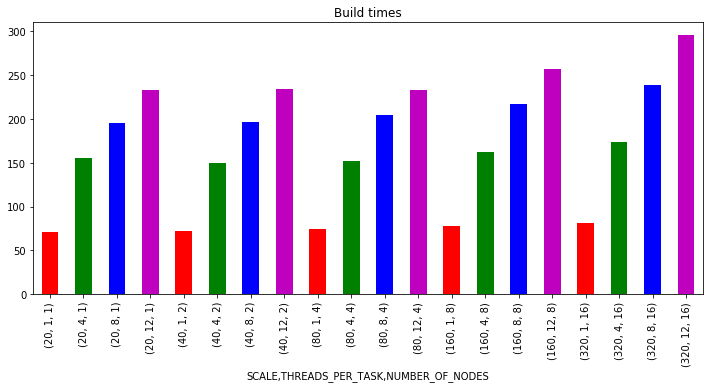

In [9]:
hpc_pres['T_bld'].plot(kind='bar', title='Build times',
                       color = ['r', 'g', 'b', 'm']*int(len(hpc_pres)/4), figsize=(12,5))

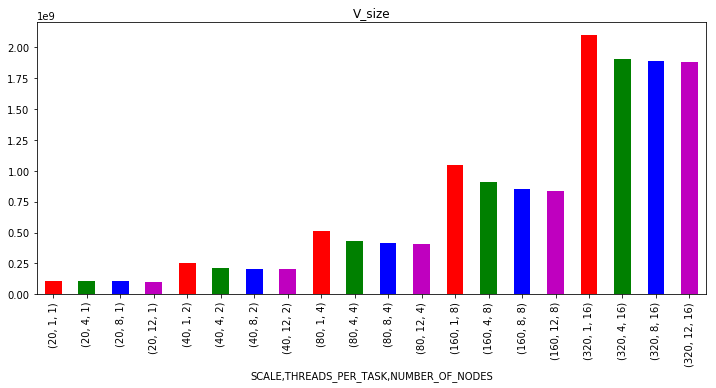

In [10]:
hpc_pres['VSize_sum'].plot(kind='bar', title='V_size',
                           color = ['r', 'g', 'b', 'm']*int(len(hpc_pres)/4), figsize=(12,5))

# HPC Benchmark - split into many `Connect` calls

We time each EE, EI, IE and II connection group, and add all these times to find total `Connect` time. Here we can also look at Connection/Second.

In [11]:
hpc_split_res = pd.concat([pd.read_csv(bench)
                           for bench in glob.glob(hpc_split_path)])

In [12]:
print(hpc_split_res)

   NUMBER_OF_NODES  TASKS_PER_NODE  THREADS_PER_TASK  SCALE  PLASTIC  NBLOCKS  \
0                1               3                 8     20     True     1000   
1                2               3                 8     40     True     1000   
2                4               3                 8     80     True     1000   
3                8               3                 8    160     True     1000   
4               16               3                 8    320     True     1000   
0                1               6                 4     20     True     1000   
1                2               6                 4     40     True     1000   
2                4               6                 4     80     True     1000   
3                8               6                 4    160     True     1000   
4               16               6                 4    320     True     1000   
0                1               2                12     20     True     1000   
1                2          

**Find total connect time:**

In [73]:
hpc_split_res['T_bld'] = (hpc_split_res['EE_inner_conn_time'] + hpc_split_res['EI_inner_conn_time']
                          + hpc_split_res['IE_inner_conn_time'] + hpc_split_res['II_inner_conn_time'])

In [14]:
hpc_split_pres = pd.pivot_table(hpc_split_res, index=['SCALE','THREADS_PER_TASK', 'NUMBER_OF_NODES'],
                                values=['T_bld', 'VSize_sum', 'N_conns_sum', 'EE_conns_per_sec'])

In [15]:
hpc_split_pres

EE_conns_per_sec  N_conns_sum  T_bld  \
SCALE THREADS_PER_TASK NUMBER_OF_NODES                                         
20    1                1                       2173210.0   2520225000  127.0   
      4                1                       4079170.0   2520225000  291.0   
      8                1                       6694770.0   2520225000  271.0   
      12               1                       9662410.0   2520225000  218.0   
40    1                2                       2143540.0   5040450000  204.0   
      4                2                       4025640.0   5040450000  132.0   
      8                2                       7045930.0   5040450000  124.0   
      12               2                       9073600.0   5040450000  216.0   
80    1                4                       2099530.0  10080900000   65.0   
      4                4                       4079170.0  10080900000  161.0   
      8                4                       6728130.0  10080900000  223.0   
      12               4                       9210830.0  10080900000  201.0   
160   1                8                       2014930.0  20161800000  133.0   
      4                8                       4063210.0  20161800000  259.0   
      8                8                       6438540.0  20161800000  293.0   
      12               8                       8837010.0  20161800000  158.0   
320   1                16                      1874480.0  40323600000   79.0   
      4                16                      3581850.0  40323600000  172.0   
      8                16                      6040270.0  40323600000  101.0   
      12               16                      8458650.0  40323600000  289.0   

                                         VSize_sum  
SCALE THREADS_PER_TASK NUMBER_OF_NODES              
20    1                1                 108664800  
      4                1                 104721696  
      8                1                 103817380  
      12               1                 106798676  
40    1                2                 254238928  
      4                2                 217630192  
      8                2                 207664892  
      12               2                 203850224  
80    1                4                 508691560  
      4                4                 433315720  
      8                4                 413882160  
      12               4                 410073768  
160   1                8                1045363384  
      4                8                 895655320  
      8                8                 846513400  
      12               8                 829445976  
320   1                16               2096415352  
      4                16               1912147448  
      8                16               1858072312  
      12               16               1884079472

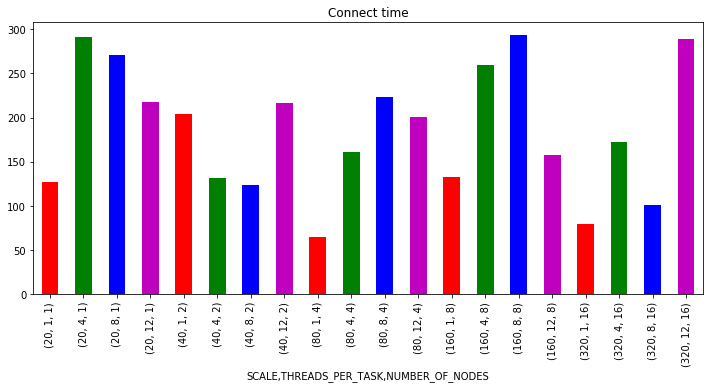

In [75]:
hpc_split_pres['T_bld'].plot(kind='bar', title='Connect time',
                             color = ['r', 'g', 'b', 'm']*int(len(hpc_split_pres)/4), figsize=(12,5))

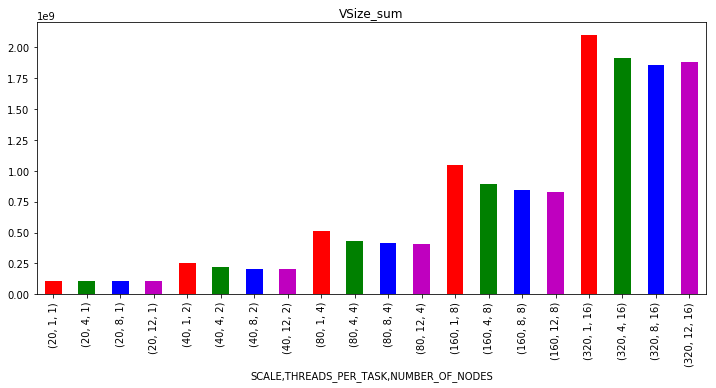

In [18]:
hpc_split_pres['VSize_sum'].plot(kind='bar', title='VSize_sum',
                                 color = ['r', 'g', 'b', 'm']*int(len(hpc_split_pres)/4), figsize=(12,5))

## HPC split - no connect per sec

Here, we have a setup closer to the normal HPC Benchmark, we start timing before first `Connect` call and stop timing when we have done our last `Connect`. The time here is thus total time for *all* EE, EI, IE, II `Connect` groups. It is not possible here to find Connect/second.

In [19]:
hpc_split_new_res = pd.concat([pd.read_csv(bench)
                               for bench in glob.glob(hpc_split_new_path)])

**Connect time:**

In [20]:
hpc_split_new_res['T_bld_xn'] = hpc_split_new_res['T_conns_min'] + hpc_split_new_res['T_ini_max']
hpc_split_new_res['T_bld_nx'] = hpc_split_new_res['T_conns_max'] + hpc_split_new_res['T_ini_min']

hpc_split_new_res['T_bld'] = hpc_split_new_res[['T_bld_xn', 'T_bld_nx']].min(axis=1)

In [21]:
hpc_split_new_pres = pd.pivot_table(hpc_split_new_res, index=['SCALE','THREADS_PER_TASK', 'NUMBER_OF_NODES'],
                                    values=['T_bld', 'VSize_sum', 'N_nrns', 'N_conns_sum'])

hpc_split_new_pres

N_conns_sum   N_nrns   T_bld  \
SCALE THREADS_PER_TASK NUMBER_OF_NODES                                 
20    1                1                 2520451000   225000   94.00   
      4                1                 2520451000   225000  182.06   
      8                1                 2520451000   225000  232.33   
      12               1                 2520451000   225000  259.81   
40    1                2                 5040901000   450000   98.13   
      4                2                 5040901000   450000  186.45   
      8                2                 5040901000   450000  236.76   
      12               2                 5040901000   450000  257.24   
80    1                4                10081801000   900000  101.34   
      4                4                10081801000   900000  190.25   
      8                4                10081801000   900000  249.48   
      12               4                10081801000   900000  279.93   
160   1                8                20163601000  1800000  111.51   
      4                8                20163601000  1800000  208.07   
      8                8                20163601000  1800000  261.81   
      12               8                20163601000  1800000  301.68   
320   1                16               40327201000  3600000  118.89   
      4                16               40327201000  3600000  218.20   
      8                16               40327201000  3600000  302.19   
      12               16               40327201000  3600000  335.13   

                                         VSize_sum  
SCALE THREADS_PER_TASK NUMBER_OF_NODES              
20    1                1                 108664800  
      4                1                 104721696  
      8                1                 102920352  
      12               1                 101874796  
40    1                2                 261021904  
      4                2                 218385904  
      8                2                 207646464  
      12               2                 203856372  
80    1                4                 522257512  
      4                4                 431669128  
      8                4                 420370216  
      12               4                 414098088  
160   1                8                1072494616  
      4                8                 924194200  
      8                8                 864429304  
      12               8                 843947864  
320   1                16               2151668344  
      4                16               1920798200  
      8                16               1889992440  
      12               16               1884720504

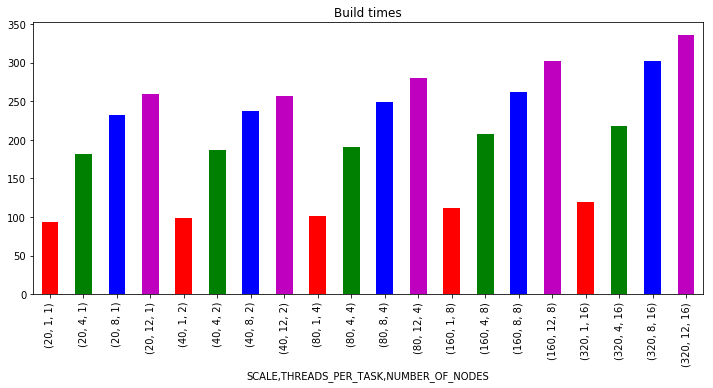

In [22]:
hpc_split_new_pres['T_bld'].plot(kind='bar', title='Build times',
                                 color = ['r', 'g', 'b', 'm']*int(len(hpc_split_new_pres)/4), figsize=(12,5))

# HPC Benchmark - only `one_to_one` calls

I think `one_to_one` is set up with too few connections, and so the result is not really that good.
It is not possible to compare connection times between the different rules, because we have different number of connections, but it is possible to compare connection/second.

In [ ]:
hpc_one_res = pd.concat([pd.read_csv(bench)
                         for bench in glob.glob(hpc_one_path)])

In [ ]:
print(hpc_one_res)

In [ ]:
hpc_one_res['T_bld'] = hpc_one_res['EE_inner_conn_time'] + hpc_one_res['EI_inner_conn_time'] + hpc_one_res['IE_inner_conn_time'] + hpc_one_res['II_inner_conn_time']

In [ ]:
hpc_one_pres = pd.pivot_table(hpc_one_res, index=['SCALE','THREADS_PER_TASK', 'NUMBER_OF_NODES'],
                              values=['T_bld', 'VSize_sum', 'N_conns_sum', 'EE_conns_per_sec'])
hpc_one_pres

In [ ]:
hpc_one_pres['T_bld'].plot(kind='bar', title='Build times',
                           color = ['r', 'g', 'b', 'm']*int(len(hpc_split_pres)/4), figsize=(12,5))

In [ ]:
hpc_one_pres['EE_conns_per_sec'].plot(kind='bar', title='EE conns per sec',
                                      color = ['r', 'g', 'b']*int(len(hpc_split_pres)/3), figsize=(12,5))

# HBC Benchmark - only `fixed_indegree` calls

In [23]:
hpc_in_res = pd.concat([pd.read_csv(bench)
                        for bench in glob.glob(hpc_in_path)])

In [24]:
print(hpc_in_res)

   NUMBER_OF_NODES  TASKS_PER_NODE  THREADS_PER_TASK  SCALE  PLASTIC RULE  \
0                1               3                 8     20     True   in   
1                2               3                 8     40     True   in   
2                4               3                 8     80     True   in   
3                8               3                 8    160     True   in   
4               16               3                 8    320     True   in   
0                1               2                12     20     True   in   
1                2               2                12     40     True   in   
2                4               2                12     80     True   in   
3                8               2                12    160     True   in   
4               16               2                12    320     True   in   
0                1              24                 1     20     True   in   
1                2              24                 1     40     True   in   

In [25]:
hpc_in_res['T_bld'] = hpc_in_res['EE_inner_conn_time'] + hpc_in_res['EI_inner_conn_time'] + hpc_in_res['IE_inner_conn_time'] + hpc_in_res['II_inner_conn_time']

In [26]:
hpc_in_pres = pd.pivot_table(hpc_in_res, index=['SCALE','THREADS_PER_TASK', 'NUMBER_OF_NODES'],
                             values=['T_bld', 'VSize_sum', 'N_conns_sum', 'EE_conns_per_sec'])
hpc_in_pres

EE_conns_per_sec  N_conns_sum  T_bld  \
SCALE THREADS_PER_TASK NUMBER_OF_NODES                                         
20    1                1                       2759610.0   2025225000  240.0   
      4                1                       5216380.0   2025225000  221.0   
      8                1                       8343630.0   2025225000  211.0   
      12               1                      11856000.0   2025225000  220.0   
40    1                2                       2761870.0   4050450000  149.0   
      4                2                       5254960.0   4050450000  220.0   
      8                2                       8274590.0   4050450000  211.0   
      12               2                      11961000.0   4050450000  189.0   
80    1                4                       2768660.0   8100900000  226.0   
      4                4                       5107830.0   8100900000  149.0   
      8                4                       8421710.0   8100900000   17.0   
      12               4                      12035700.0   8100900000  142.0   
160   1                8                       2761870.0  16201800000  226.0   
      4                8                       5338080.0  16201800000  102.0   
      8                8                       8216680.0  16201800000  200.0   
      12               8                      11688300.0  16201800000  219.0   
320   1                16                      2752850.0  32403600000  245.0   
      4                16                      5094340.0  32403600000  249.0   
      8                16                      8517350.0  32403600000  139.0   
      12               16                     11427800.0  32403600000  235.0   

                                         VSize_sum  
SCALE THREADS_PER_TASK NUMBER_OF_NODES              
20    1                1                  92936160  
      4                1                  84022560  
      8                1                  83173536  
      12               1                  82930792  
40    1                2                 185032912  
      4                2                 168306160  
      8                2                 166457084  
      12               2                 165919216  
80    1                4                 383845480  
      4                4                 337946504  
      8                4                 341260180  
      12               4                 331870884  
160   1                8                 768538648  
      4                8                 716105112  
      8                8                 669168888  
      12               8                 666206032  
320   1                16               1794423928  
      4                16               1361186296  
      8                16               1334681336  
      12               16               1329812856

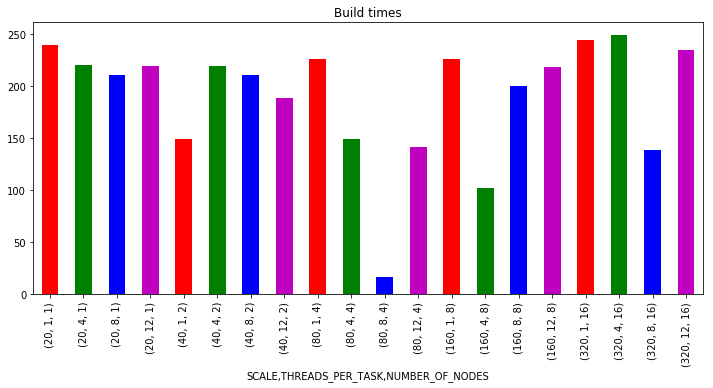

In [27]:
hpc_in_pres['T_bld'].plot(kind='bar', title='Build times',
                          color = ['r', 'g', 'b', 'm']*int(len(hpc_split_pres)/4), figsize=(12,5))

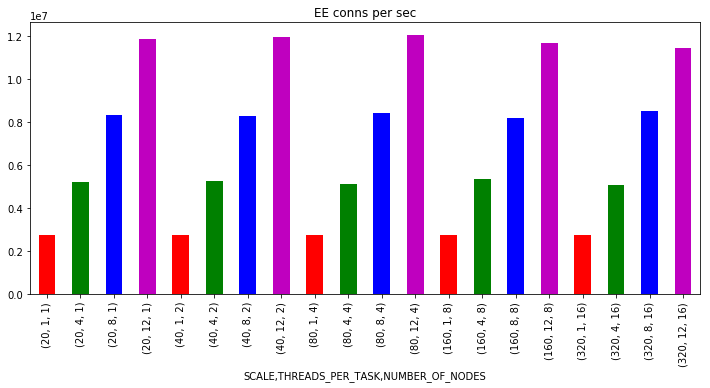

In [28]:
hpc_in_pres['EE_conns_per_sec'].plot(kind='bar', title='EE conns per sec',
                                     color = ['r', 'g', 'b', 'm']*int(len(hpc_split_pres)/4), figsize=(12,5))

### Connections per second for both `one_to_one` and `fixed_indegree`, ex - ex connections:

In [ ]:
hpc_one_in_res = pd.concat([hpc_one_res, hpc_in_res])
hpc_one_in_pres = pd.pivot_table(hpc_one_in_res, index=['RULE','SCALE','THREADS_PER_TASK', 'NUMBER_OF_NODES'],
                                 values=['EE_conns_per_sec'])
hpc_one_in_pres

In [ ]:
hpc_one_in_pres['EE_conns_per_sec'].plot(kind='bar', title='EE conns per sec',
                                         color = ['r', 'g', 'b']*int(len(hpc_split_pres)/3), figsize=(12,5))

# Connections/Second for all `Connect` rules for thread = 4

We had asked for too little time for `fixed_indegree`, `fixed_total_number`, `symmetric_pairwise_bernoulli` and I think `all_to_all`, which results in the NaN values below. Piz Daint is down until tomorrow evening (13th of December), so can't allocate more time until then.

In [86]:
path_list = [path_string.replace('*', '4') for path_string in
             [hpc_one_path, hpc_all_path, hpc_in_path, hpc_out_path,
              hpc_tot_path, hpc_bern_path, hpc_bern_sym_path]]

connSec_res = pd.concat([pd.read_csv(bench)
                         for bench in path_list])


In [87]:
print(connSec_res)

   NUMBER_OF_NODES  TASKS_PER_NODE  THREADS_PER_TASK  SCALE  PLASTIC  \
0                1               6                 4     20     True   
1                2               6                 4     40     True   
2                4               6                 4     80     True   
3                8               6                 4    160     True   
4               16               6                 4    320     True   
0                1               6                 4     20     True   
1                2               6                 4     40     True   
2                4               6                 4     80     True   
3                8               6                 4    160     True   
4               16               6                 4    320     True   
0                1               6                 4     20     True   
1                2               6                 4     40     True   
2                4               6                 4     80     

In [89]:
connSec_res['T_bld'] = (connSec_res['EE_inner_conn_time'] + connSec_res['EI_inner_conn_time']
                        + connSec_res['IE_inner_conn_time'] + connSec_res['II_inner_conn_time'])

In [90]:
connSec_pres = pd.pivot_table(connSec_res, index=['RULE', 'SCALE', 'NUMBER_OF_NODES'],
                              values=['T_bld', 'VSize_sum', 'N_conns_sum', 'EE_conns_per_sec', 'EI_conns_per_sec'])
connSec_pres

EE_conns_per_sec  EI_conns_per_sec  \
RULE     SCALE NUMBER_OF_NODES                                       
all      20    1                       5658890.0         5549850.0   
         40    2                       5707420.0         6288430.0   
         80    4                       5811140.0         6221200.0   
         160   8                       5699510.0         6224470.0   
         320   16                      5541300.0         6178490.0   
bern     20    1                       2348670.0         2476190.0   
         40    2                       1498230.0         1547350.0   
         80    4                        868365.0          883570.0   
         160   8                        471816.0          478002.0   
         320   16                       246388.0          236067.0   
in       20    1                       5216380.0         5615640.0   
         40    2                       5254960.0         5569310.0   
         80    4                       5107830.0         5560130.0   
         160   8                       5338080.0         5962900.0   
         320   16                      5094340.0         6059250.0   
one      20    1                             NaN         3000000.0   
         40    2                        750000.0         3000000.0   
         80    4                       3000000.0         3000000.0   
         160   8                       3000000.0         3000000.0   
         320   16                      3000000.0         3000000.0   
out      20    1                       1321630.0         1564900.0   
         40    2                        799975.0          911786.0   
         80    4                        444243.0          511654.0   
         160   8                        234862.0          271073.0   
         320   16                       120253.0          149775.0   
sym-bern 20    1                        286317.0          101454.0   
         40    2                         90576.1           27277.1   
         80    4                         25268.6               NaN   
         160   8                             NaN               NaN   
         320   16                            NaN               NaN   
tot      20    1                             NaN               NaN   
         40    2                             NaN               NaN   
         80    4                             NaN               NaN   
         160   8                             NaN               NaN   
         320   16                            NaN               NaN   

                                 N_conns_sum  T_bld     VSize_sum  
RULE     SCALE NUMBER_OF_NODES                                     
all      20    1                2.025045e+09  189.0  8.368625e+07  
         40    2                4.050113e+09  220.0  1.678671e+08  
         80    4                8.100090e+09  178.0  3.350299e+08  
         160   8                1.620007e+10  225.0           NaN  
         320   16               3.240018e+10  258.0  1.340427e+09  
bern     20    1                2.025213e+09  245.0  8.402256e+07  
         40    2                4.050402e+09  179.0  1.681833e+08  
         80    4                8.100980e+09  201.0  3.384483e+08  
         160   8                1.620168e+10  165.0  7.122037e+08  
         320   16               3.240382e+10  283.0  1.366429e+09  
in       20    1                2.025225e+09  221.0  8.402256e+07  
         40    2                4.050450e+09  220.0  1.683062e+08  
         80    4                8.100900e+09  149.0  3.379465e+08  
         160   8                1.620180e+10  102.0  7.161051e+08  
         320   16               3.240360e+10  249.0  1.361186e+09  
one      20    1                1.080000e+06    1.0  4.249048e+06  
         40    2                2.160000e+06    6.0  9.576276e+06  
         80    4                4.320000e+06    2.0  2.104991e+07  
         160   8                8.640000e+06    3.0  5.244388e+07  
         320 

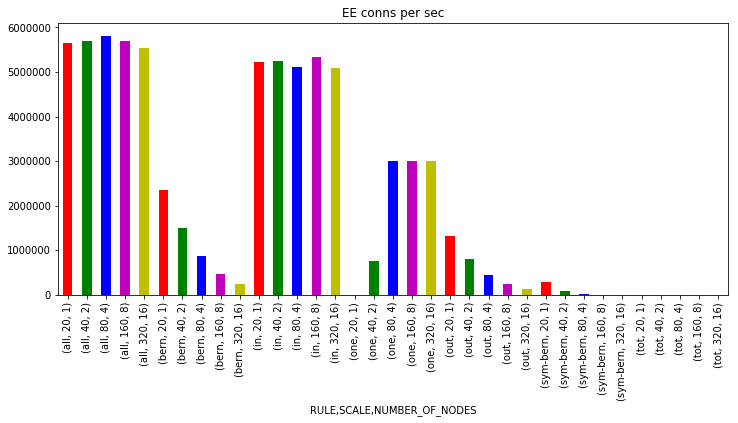

In [91]:
connSec_pres['EE_conns_per_sec'].plot(kind='bar', title='EE conns per sec',
                                      color = ['r', 'g', 'b', 'm', 'y']*int(len(connSec_pres)/5), figsize=(12,5))

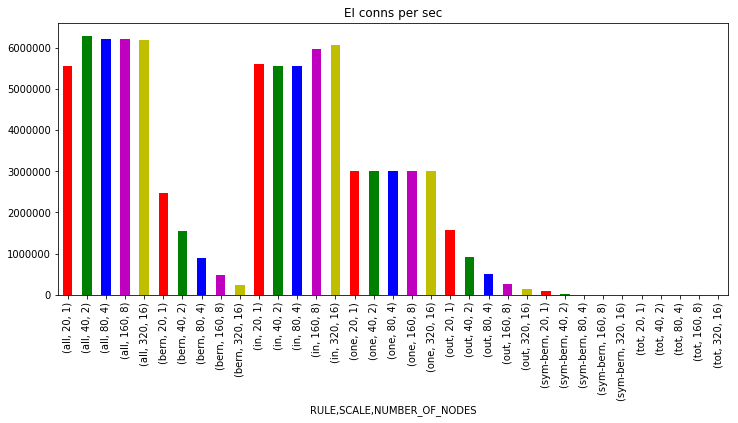

In [92]:
connSec_pres['EI_conns_per_sec'].plot(kind='bar', title='EI conns per sec',
                                      color = ['r', 'g', 'b', 'm', 'y']*int(len(connSec_pres)/5), figsize=(12,5))

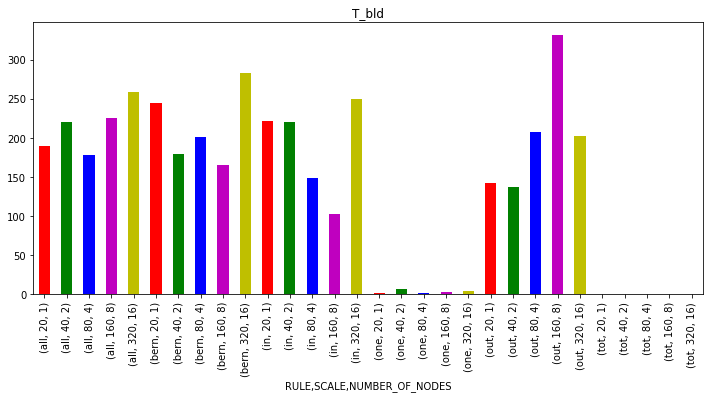

In [82]:
connSec_pres['T_bld'].plot(kind='bar', title='T_bld',
                             color = ['r', 'g', 'b', 'm', 'y']*int(len(connSec_pres)/5), figsize=(12,5))

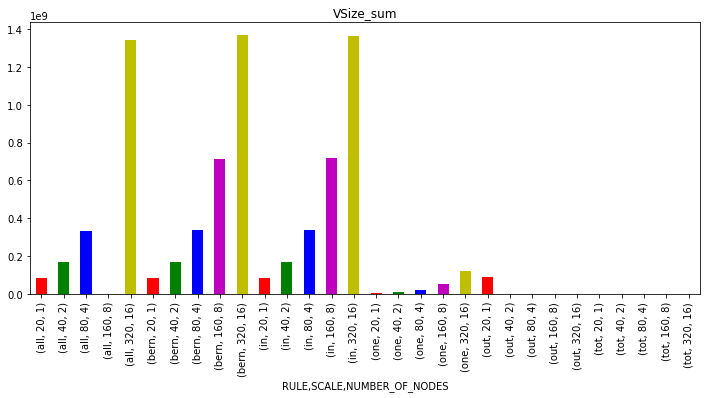

In [83]:
connSec_pres['VSize_sum'].plot(kind='bar', title='VSize_sum',
                               color = ['r', 'g', 'b', 'm', 'y']*int(len(connSec_pres)/5), figsize=(12,5))

# REALISTIC MODELS

# Multi-Area-Model
Currently only have results for 4, 8, 12 threads

In [43]:
mam_res = pd.concat([pd.read_csv(bench)
                     for bench in glob.glob(mam_path)])

In [44]:
print(mam_res)

   NUMBER_OF_NODES  TASKS_PER_NODE  NUM_VPS  THREADS_PER_TASK   SCALE  \
0                1               6       24                 4  0.0625   
1                2               6       48                 4  0.1250   
2                4               6       96                 4  0.2500   
3                8               6      192                 4  0.5000   
4               16               6      384                 4  1.0000   
0                1               3       24                 8  0.0625   
1                2               3       48                 8  0.1250   
2                4               3       96                 8  0.2500   
3                8               3      192                 8  0.5000   
4               16               3      384                 8  1.0000   
0                1               2       24                12  0.0625   
1                2               2       48                12  0.1250   
2                4               2       96        

In [45]:
mam_pres = pd.pivot_table(mam_res, index=['SCALE','THREADS_PER_TASK', 'NUMBER_OF_NODES'],
                          values=['T_connect_avg', 'VSize_sum', 'N_conns_sum'])

In [46]:
mam_pres

N_conns_sum  T_connect_avg  \
SCALE  THREADS_PER_TASK NUMBER_OF_NODES                               
0.0625 4                1                   94756223       8.303144   
       8                1                   94756223       9.558792   
       12               1                   94756223      10.672376   
0.1250 4                2                  378005043      14.137301   
       8                2                  378005043      16.970994   
       12               2                  378005043      17.811317   
0.2500 4                4                 1509968177      25.409213   
       8                4                 1509968177      30.562368   
       12               4                 1509968177      32.847020   
0.5000 4                8                 6035755838      48.192471   
       8                8                 6035755838      57.141467   
       12               8                 6035755838      61.521174   
1.0000 4                16               24134776576      90.925531   
       8                16               24134776576     107.590100   
       12               16               24134776576     114.698663   

                                          VSize_sum  
SCALE  THREADS_PER_TASK NUMBER_OF_NODES              
0.0625 4                1                  29724120  
       8                1                  26854488  
       12               1                  25748196  
0.1250 4                2                  70496096  
       8                2                  64343736  
       12               2                  61441836  
0.2500 4                4                 185137768  
       8                4                 174597844  
       12               4                 167763380  
0.5000 4                8                 548592472  
       8                8                 514205756  
       12               8                 474101912  
1.0000 4                16               1781781752  
       8                16               1532650104  
       12               16               1486488184

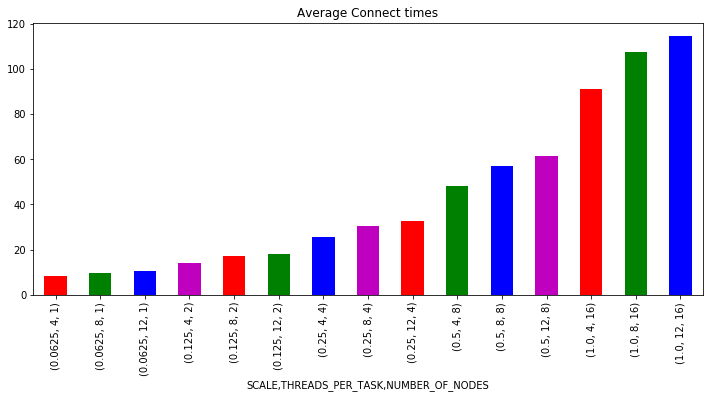

In [93]:
mam_pres['T_connect_avg'].plot(kind='bar', title='Average Connect times',
                               color = ['r', 'g', 'b', 'm']*int(len(hpc_split_pres)/4), figsize=(12,5))

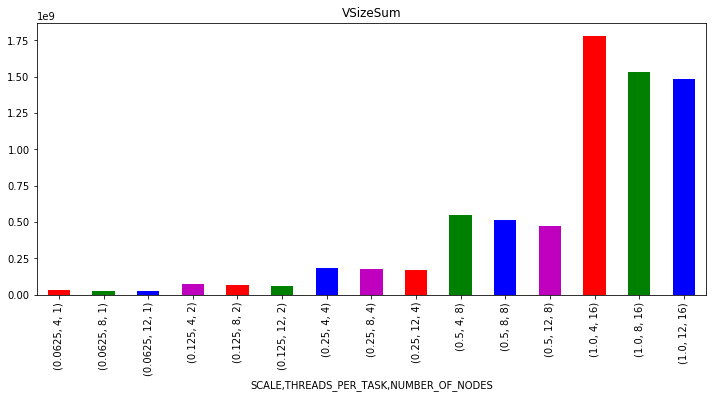

In [48]:
mam_pres['VSize_sum'].plot(kind='bar', title='VSizeSum',
                           color = ['r', 'g', 'b', 'm']*int(len(hpc_split_pres)/4), figsize=(12,5))

# 4x4 mesocircuit

In [35]:
meso_res = pd.concat([pd.read_csv(bench)
                      for bench in glob.glob(mesocircuit_path)])

In [36]:
print(meso_res)

   NUMBER_OF_NODES  TASKS_PER_NODE  THREADS_PER_TASK   SCALE  \
0                1              24                 1  0.0625   
1                2              24                 1  0.1250   
2                4              24                 1  0.2500   
3                8              24                 1  0.5000   
4               16              24                 1  1.0000   
0                1               3                 8  0.0625   
1                2               3                 8  0.1250   
2                4               3                 8  0.2500   
3                8               3                 8  0.5000   
4               16               3                 8  1.0000   
0                1               2                12  0.0625   
1                2               2                12  0.1250   
2                4               2                12  0.2500   
3                8               2                12  0.5000   
4               16               2      

In [37]:
meso_pres = pd.pivot_table(meso_res, index=['SCALE','THREADS_PER_TASK', 'NUMBER_OF_NODES'],
                           values=['T_conns_avg', 'VSize_sum', 'N_conns_sum'])

In [38]:
meso_pres

N_conns_sum  T_conns_avg  VSize_sum
SCALE  THREADS_PER_TASK NUMBER_OF_NODES                                     
0.0625 1                1                  345513663   147.686667   40128480
       4                1                  345513663   222.121667   23614752
       8                1                  345513663   276.153333   21930984
       12               1                  345513663   275.895000   21403204
0.1250 1                2                  690961118   156.176042   70312296
       4                2                  690961118   235.279167   49554928
       8                2                  690961118   282.273333   44443016
       12               2                  690961118   273.705000   43437476
0.2500 1                4                 1382076915   192.519063  156659176
       4                4                 1382076915   316.797083  105088904
       8                4                 1382076915   343.160000   91407432
       12               4                 1382076915   341.207500   91423736
0.5000 1                8                 2764017366   279.417812  314313496
       4                8                 2764017366   453.051458  199482776
       8                8                 2764017366   506.747917  197921848
       12               8                 2764017366   482.738125  186905064
1.0000 1                16                5527838034   457.390573  710875768
       4                16                5527838034   691.948125  450616824
       8                16                5527838034   781.359583  414584568
       12               16                5527838034   765.175938  410852724

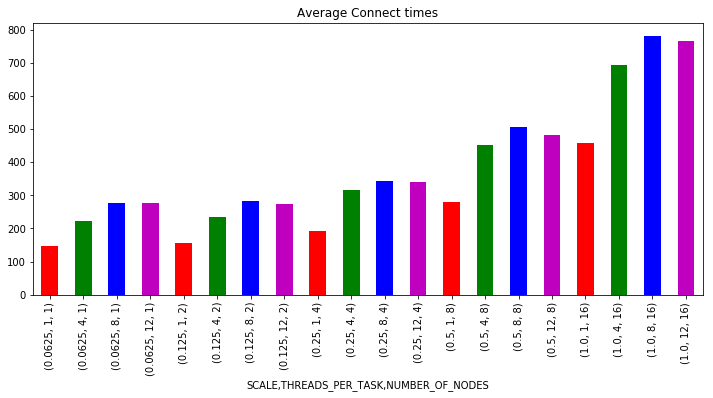

In [94]:
meso_pres['T_conns_avg'].plot(kind='bar', title='Average Connect times',
                              color = ['r', 'g', 'b', 'm']*int(len(hpc_split_pres)/4), figsize=(12,5))

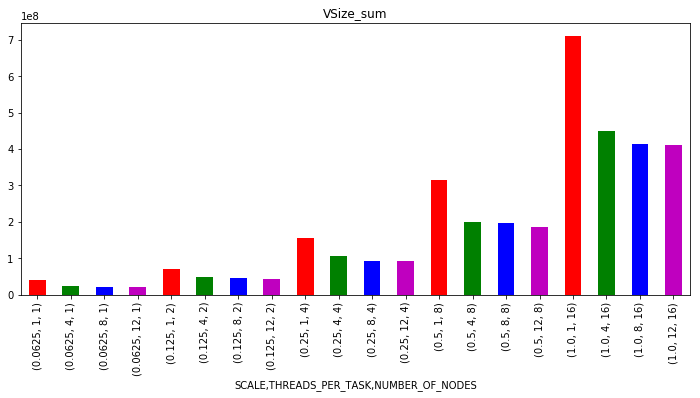

In [42]:
meso_pres['VSize_sum'].plot(kind='bar', title='VSize_sum',
                            color = ['r', 'g', 'b', 'm']*int(len(hpc_split_pres)/4), figsize=(12,5))